# Predicting Brand Exposure

## 02_Build Models
* Load in data from previous steps
* Train and Evaluate various models
    * <strong>Try Some Regression Models and compare performance</strong>
        * Random Forest Regressor
        * SVR Support Vector Regression
        * MLP with last layer fully connected, no activation
            * [Update] Due to a small dataset, it is proving difficult to train this MLP. 
    * <strong>Try converting the Weekly Count traget feature to a categorical label and model with a classification algorithm</strong>        
        * Random Forest Classification
        * SVM
        * MLP with softmax activation on final layer  
          
* Identify model that performs best and save for future use

## Import and Load Data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel('../data_archives/df_processed.xlsx')

In [2]:
#inspect data
df.head()

,index,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type
0,0,Ellis PC,42.348034,-71.041187,ChIJq6qaXoJ644kRoNxCzt2rYyw,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance
1,1,"WithumSmith+Brown, PC",42.349607,-71.042722,ChIJydm7oHhw44kRYeJauZOvntA,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance
2,2,Cantor Stefanie D,42.349819,-71.042828,ChIJ0VvNp3hw44kRxv4C86Zgsi8,"['lawyer', 'accounting', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,professional_services
3,3,Goodwin Procter Boston,42.352191,-71.043785,ChIJzyWROoRw44kR__T4RIymGyw,"['accounting', 'lawyer', 'finance', 'point_of_...",690,947,788,1020,630,0,0,4075,finance
4,4,PwC,42.351162,-71.045188,ChIJ30VlLIJw44kRk4x9eEYUtbg,"['accounting', 'finance', 'point_of_interest',...",525,558,575,644,755,0,0,3057,finance


## Prepare Train, Test, and Validation Data

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from pandas import get_dummies

#split data into features and labels
X = df[df['WeekTotals']>0][['lat','long','mapped_venue_type']]
y = df[df['WeekTotals']>0]['WeekTotals']

#normalize lat and long
scaler = MinMaxScaler()
scaler.fit(X[['lat','long']])
X[['lat','long']] = scaler.transform(X[['lat','long']])

#encode categorical variable
X = pd.get_dummies(X, columns=["mapped_venue_type"])

#convert to array
X = np.array(X)
y = np.array(y)

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

## Build Random Forest

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [6]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
#define parameters to search
param_grid = {
    'n_estimators': [10,20,30,40,50,100],
    'max_features':[9,10,11,12,13,14,15],
    'max_depth':[40,45,50,75,100],
    'min_samples_split':[40,45,50,55,60]
}

#create regressor object
regr = RandomForestRegressor(min_samples_leaf=2,criterion='mse',random_state=2222)
#create grid search object
grid_search = GridSearchCV(estimator = regr, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)
#fit grid search object
grid_search.fit(X_train, y_train)
print("========================================")
print("Finished training")
print("========================================")
print("Parameters of best estimator...")
best_grid = grid_search.best_estimator_
print(grid_search.best_params_)
print("========================================")
print("Best estimator accuracy...")
grid_accuracy = evaluate(best_grid, X_test, y_test)
print(grid_accuracy)

Fitting 3 folds for each of 1050 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   18.6s


Finished training
Parameters of best estimator...
{'max_depth': 40, 'max_features': 12, 'min_samples_split': 40, 'n_estimators': 40}
Best estimator accuracy...
Model Performance
Average Error: 927.5984 degrees.
Accuracy = 64.92%.
64.9157590076


[Parallel(n_jobs=-1)]: Done 3150 out of 3150 | elapsed:   28.1s finished


#### Random Forest Performance: 64.92%

## SVR - Support Vector Regression

In [8]:
#import libraries
from sklearn.svm import SVR

In [9]:
#create svr object
svr = SVR()

#define parameter grid
svr_param_grid = {
    'C': np.arange(1.0,4.0,1.0),
    'epsilon':np.arange(0.1,1.0,0.1),
    'kernel':['linear','poly','rbf','sigmoid'],
    'degree':range(2,6,1),
    'gamma':['auto'],
    'max_iter':[100]
}

#create grid search object
grid_search_svr = GridSearchCV(estimator=svr, param_grid=svr_param_grid, cv=3, n_jobs=-1, verbose=1)
#fit the grid search object
grid_search_svr.fit(X_train, y_train)

print("========================================")
print("Finished training")
print("========================================")
print("Parameters of best estimator...")
svr_best_grid = grid_search_svr.best_estimator_
print(grid_search_svr.best_params_)
print("========================================")
print("Best estimator accuracy...")
svr_grid_accuracy = evaluate(svr_best_grid, X_test, y_test)
print(svr_grid_accuracy)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Applica

Finished training
Parameters of best estimator...
{'C': 3.0, 'degree': 2, 'epsilon': 0.10000000000000001, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 100}
Best estimator accuracy...
Model Performance
Average Error: 1062.7448 degrees.
Accuracy = 68.98%.
68.9802613017


[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:    1.1s finished
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


#### SVR Performance: 68.98%

## MLP Regression

In [723]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import numpy as np

In [768]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [769]:
mlp_model = Sequential()
mlp_model.add(Dense(16,activation='linear',input_shape=(15,)))
#mlp_model.add(Dense(32, activation='linear'))
#mlp_model.add(Dropout(rate=0.1))
#mlp_model.add(Dense(64, activation='linear'))
#mlp_model.add(Dropout(rate=0.1))
#mlp_model.add(Dense(128, activation='linear'))
mlp_model.add(Dropout(rate=0.1))
mlp_model.add(Dense(1))
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 16)                256       
_________________________________________________________________
dropout_130 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_262 (Dense)            (None, 1)                 17        
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [770]:
#compile model
loss = 'mean_absolute_error'
optimizer = 'adam'
metrics=['mae','acc']

mlp_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [771]:
#train model
#earlystop = EarlyStopping(monitor='val_mean_absolute_error',min_delta=0.1, patience=5)
checkpoint = ModelCheckpoint('./saved_models/mlp_regression/mlp_regression.best.hdf5',
                             monitor='acc',save_best_only=True,)

epochs = 100

model_hist = mlp_model.fit(X_train,y_train,
                       epochs=epochs,verbose=2,callbacks=[checkpoint],
                       validation_split=.1,shuffle=True,steps_per_epoch=100,validation_steps=20)

#validation_data=(X_test,y_test),

Train on 230 samples, validate on 26 samples
Epoch 1/100
 - 3s - loss: 3122.5524 - mean_absolute_error: 3122.5524 - acc: 0.0000e+00 - val_loss: 3157.8621 - val_mean_absolute_error: 3157.8621 - val_acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 3000.5005 - mean_absolute_error: 3000.5005 - acc: 0.0000e+00 - val_loss: 3006.5315 - val_mean_absolute_error: 3006.5315 - val_acc: 0.0000e+00
Epoch 3/100
 - 0s - loss: 2814.2021 - mean_absolute_error: 2814.2021 - acc: 0.0000e+00 - val_loss: 2783.2197 - val_mean_absolute_error: 2783.2197 - val_acc: 0.0000e+00
Epoch 4/100
 - 0s - loss: 2553.7245 - mean_absolute_error: 2553.7245 - acc: 0.0000e+00 - val_loss: 2482.6021 - val_mean_absolute_error: 2482.6021 - val_acc: 0.0000e+00
Epoch 5/100
 - 0s - loss: 2225.1592 - mean_absolute_error: 2225.1592 - acc: 4.3478e-05 - val_loss: 2131.0803 - val_mean_absolute_error: 2131.0803 - val_acc: 0.0000e+00
Epoch 6/100
 - 0s - loss: 1849.6796 - mean_absolute_error: 1849.6796 - acc: 8.6957e-05 - val_loss: 1744.9790 - val_

Epoch 50/100
 - 0s - loss: 991.3347 - mean_absolute_error: 991.3347 - acc: 4.3478e-04 - val_loss: 1134.5532 - val_mean_absolute_error: 1134.5532 - val_acc: 0.0000e+00
Epoch 51/100
 - 0s - loss: 990.7215 - mean_absolute_error: 990.7215 - acc: 3.4783e-04 - val_loss: 1132.8657 - val_mean_absolute_error: 1132.8657 - val_acc: 0.0000e+00
Epoch 52/100
 - 0s - loss: 988.6938 - mean_absolute_error: 988.6938 - acc: 5.2174e-04 - val_loss: 1133.0795 - val_mean_absolute_error: 1133.0795 - val_acc: 0.0000e+00
Epoch 53/100
 - 0s - loss: 988.2293 - mean_absolute_error: 988.2293 - acc: 3.9130e-04 - val_loss: 1133.3026 - val_mean_absolute_error: 1133.3026 - val_acc: 0.0000e+00
Epoch 54/100
 - 0s - loss: 988.6650 - mean_absolute_error: 988.6650 - acc: 5.2174e-04 - val_loss: 1131.5748 - val_mean_absolute_error: 1131.5748 - val_acc: 0.0000e+00
Epoch 55/100
 - 0s - loss: 987.5292 - mean_absolute_error: 987.5292 - acc: 3.0435e-04 - val_loss: 1131.9359 - val_mean_absolute_error: 1131.9359 - val_acc: 0.0000e+0

 - 0s - loss: 959.4401 - mean_absolute_error: 959.4401 - acc: 4.3478e-04 - val_loss: 1125.8085 - val_mean_absolute_error: 1125.8085 - val_acc: 0.0000e+00
Epoch 100/100
 - 0s - loss: 956.6286 - mean_absolute_error: 956.6286 - acc: 4.7826e-04 - val_loss: 1126.0341 - val_mean_absolute_error: 1126.0341 - val_acc: 0.0000e+00


dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])


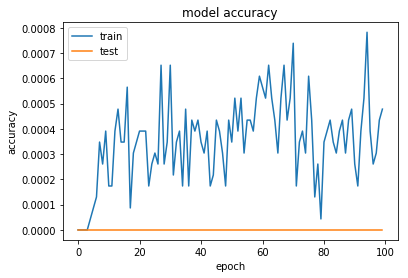

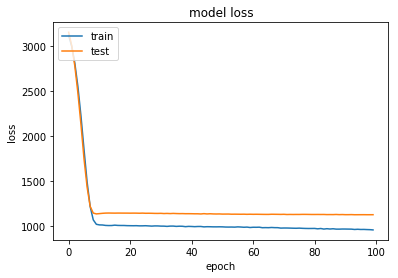

In [772]:
import matplotlib.pyplot as plt

# list all data in history
print(model_hist.history.keys())
# summarize history for mae
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [773]:
print(mlp_model.metrics_names)
print(mlp_model.evaluate(X_test,y_test_log,verbose=0))

['loss', 'mean_absolute_error', 'acc']
[3070.3497314453125, 3070.3497314453125, 0.0]


In [774]:
#load best weights
mlp_model.load_weights('./saved_models/mlp_regression/mlp_regression.best.hdf5')
#compile model
loss = 'mean_absolute_error'
optimizer = 'adam'
metrics=['mae','acc']

mlp_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
print("--bestl weights--")
pred = mlp_model.predict(X_test[i].reshape(1,-1))
actual = y_test[i]
print("prediction:",pred)
print("actual:",actual)

--bestl weights--
prediction: [[ 2897.43994141]]
actual: 3836


In [775]:
mlp_preds = []
mlp_acts = []
mlp_diffs = []
for i in range(len(y_test)):
    mlp_prediction = list(mlp_model.predict(X_test[i].reshape(1,-1)))
    mlp_actual = y_test[i]
    mlp_preds.append(mlp_prediction[0][0])
    mlp_acts.append(mlp_actual)
    mlp_diffs.append(np.abs(mlp_actual-mlp_prediction[0][0]))

(0, 8000)

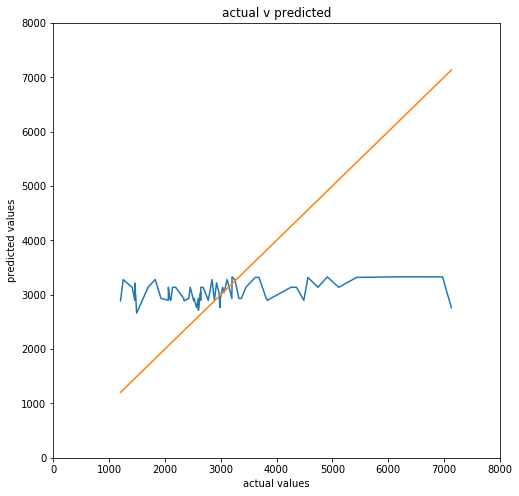

In [778]:
import seaborn as sns
%matplotlib inline

a = list(np.arange(0,8000,100))

f, ax = plt.subplots(1,figsize=(8,8))
sns.lineplot(x=mlp_acts,y=mlp_preds)
sns.lineplot(x=mlp_acts,y=mlp_acts)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('actual v predicted')
                     
ax.set_xlim([0, 8000])
ax.set_ylim([0,8000])

#### To Do: Tune and Evaluate Model

## The Random Forest Regression model gives us the best performance.

Below we will save the model for future use

In [751]:
#prepare model to be saved
import pandas
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle

#prepare data
df = pd.read_excel('../data_archives/df_processed.xlsx')

#split data into features and labels
X = df[df['WeekTotals']>0][['lat','long','mapped_venue_type']]
y = df[df['WeekTotals']>0]['WeekTotals']

'''#normalize lat and long
scaler = MinMaxScaler()
scaler.fit(X[['lat','long']])
X[['lat','long']] = scaler.transform(X[['lat','long']])'''

#encode categorical variable
X = pd.get_dummies(X, columns=["mapped_venue_type"])

#test performance for log_transformed y_values
y_log = np.array(np.log(y))

#convert to array
X = np.array(X)
y = np.array(y)

#split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

# Fit the model on 80%
final_model=RandomForestRegressor(min_samples_leaf=2,criterion='mae', max_depth=10, 
                            max_features=12, min_samples_split=40, n_estimators=100,
                            min_impurity_decrease=.5,random_state=42)
final_model.fit(X_train, y_train)

# save the model to disk
filename = './saved_models/FinalModel/Model_CommercialActivityModel.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [752]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.377484651816


In [753]:
preds = []
acts = []
diffs = []
for i in range(len(y_test)):
    prediction = list(loaded_model.predict(X_test[i].reshape(1,-1)))
    actual = y_test[i]
    preds.append(prediction[0])
    acts.append(actual)
    diffs.append(np.abs(actual-prediction[0]))

(0, 8000)

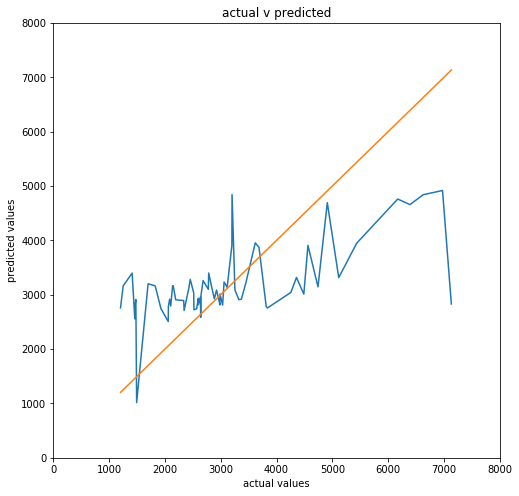

In [779]:
import seaborn as sns
%matplotlib inline

a = list(np.arange(0,8000,100))

f, ax = plt.subplots(1,figsize=(8,8))
sns.lineplot(x=acts,y=preds)
sns.lineplot(x=acts,y=acts)

plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('actual v predicted')
                     
ax.set_xlim([0, 8000])
ax.set_ylim([0,8000])

In the above graph plots the actual values against the predicted values. The orange line show what perfect predictions would look like. (ex. if the actual value is 2000 and the model predicted 2000, it would fall on the orange line). The blue line represents the model's output predictions against the actual values.